In [2]:
import numpy as np

# Input vector
vector = np.array([-1.050374, 1.050374, 2.12237])

# Normalize the vector
norm = np.linalg.norm(vector)
direction = vector / norm

# Extract components
x, y, z = direction

# Compute RPY
pitch = np.arcsin(-z)  # Rotation around Y-axis
yaw = np.arctan2(y, x)  # Rotation around Z-axis
roll = 0  # Default as 0 if no secondary orientation is provided

# Convert to degrees if needed
pitch_deg = np.degrees(pitch)
yaw_deg = np.degrees(yaw)
roll_deg = np.degrees(roll)

print(f"Roll (r): {roll:.4f} rad ({roll_deg:.2f}°)")
print(f"Pitch (p): {pitch:.4f} rad ({pitch_deg:.2f}°)")
print(f"Yaw (y): {yaw:.4f} rad ({yaw_deg:.2f}°)")

Roll (r): 0.0000 rad (0.00°)
Pitch (p): -0.9601 rad (-55.01°)
Yaw (y): 2.3562 rad (135.00°)


In [6]:
import numpy as np
from PIL import Image


def extend_periodic_image(image: Image.Image, n: int) -> Image.Image:
    """
    Extend an image with a periodic pattern n-times in both width and height, maintaining resolution.

    Args:
        image (Image.Image): Input image (PIL.Image).
        n (int): Number of times to extend the image in each dimension.

    Returns:
        Image.Image: The extended and scaled-down image.
    """
    # Convert to numpy array for manipulation
    img_array = np.array(image)

    # Tile the image n-times in both dimensions
    tiled_array = np.tile(img_array, (7, 14, 1))

    # Create a PIL image from the tiled array
    extended_image = Image.fromarray(tiled_array)

    # Scale the image back to the original size
    # original_size = image.size  # (width, height)
    # scale_size = (original_size[0] * 6, original_size[1] * 4)
    scale_size = extended_image.size
    # scaled_image = extended_image.resize(scale_size, Image.Resampling.LANCZOS)

    return extended_image


# Example usage
if __name__ == "__main__":
    # Load an image
    img = Image.open("/home/irom-lab/projects/guided-data-collection/Picture1.png")

    # Extend and scale the image
    extended_img = extend_periodic_image(img, 8)

    # Save or show the result
    extended_img.save("extended_image.png")
    extended_img.show()

libGL error: No matching fbConfigs or visuals found
libGL error: failed to load driver: swrast


In [1]:
import numpy as np
from scipy.spatial.transform import Rotation as R


def calculate_camera_global_pose(base_global, camera_robot):
    """
    Calculate the camera's pose in the global frame.

    Parameters:
        base_global (list): [x_b, y_b, z_b, w_b, x_b, y_b, z_b] (robot's pose in global frame)
        camera_robot (list): [x_c, y_c, z_c, w_c, x_c, y_c, z_c] (camera's pose in robot's frame)

    Returns:
        camera_global (list): [x_g, y_g, z_g, w_g, x_g, y_g, z_g] (camera's pose in global frame)
    """
    # Unpack inputs
    pos_b, quat_b = np.array(base_global[:3]), np.array(base_global[3:])
    pos_c, quat_c = np.array(camera_robot[:3]), np.array(camera_robot[3:])

    # Normalize quaternions
    quat_b /= np.linalg.norm(quat_b)
    quat_c /= np.linalg.norm(quat_c)

    quat_b = np.roll(quat_b, -1)
    quat_c = np.roll(quat_c, -1)

    # Convert quaternion to rotation matrix for base
    R_b = R.from_quat(quat_b).as_matrix()  # Quaternion format: [x, y, z, w]

    # Debugging: Print rotation matrix
    print("Rotation matrix R_b:\n", R_b)

    # Transform position
    pos_g = pos_b + R_b @ pos_c

    # Debugging: Print intermediate positions
    print("Base global position (pos_b):", pos_b)
    print("Camera relative position (pos_c):", pos_c)
    print("Transformed global position (pos_g):", pos_g)

    # Transform orientation (quaternion multiplication)
    quat_b_rot = R.from_quat(quat_b)
    quat_c_rot = R.from_quat(quat_c)
    quat_g_rot = quat_b_rot * quat_c_rot  # Quaternion multiplication
    quat_g = quat_g_rot.as_quat()  # Convert back to [x, y, z, w]

    # Debugging: Print resulting quaternion
    print("Resulting global quaternion (quat_g):", quat_g)

    # from x, y, z, w to w, x, y, z
    quat_g = np.roll(quat_g, 1)

    # Return global pose
    return np.concatenate([pos_g, quat_g])


# Example input
robot_base_global_pose = [-0.545, -0.4785, -0.05, 0.924, -0.0, -0.0, 0.383]
camera_robot_base_pose = [
    0.40794,
    0.71129,
    0.73127,
    0.051215,
    -0.15300,
    0.90863,
    -0.385174,
]

# Compute camera global pose
camera_global_pose = calculate_camera_global_pose(
    robot_base_global_pose, camera_robot_base_pose
)
print("Camera's pose in the global frame:", list(camera_global_pose))

Rotation matrix R_b:
 [[ 0.70675836 -0.70745503 -0.        ]
 [ 0.70745503  0.70675836  0.        ]
 [ 0.         -0.          1.        ]]
Base global position (pos_b): [-0.545  -0.4785 -0.05  ]
Camera relative position (pos_c): [0.40794 0.71129 0.73127]
Transformed global position (pos_g): [-0.75989069  0.31280936  0.68127   ]
Resulting global quaternion (quat_g): [-0.48926368  0.78079382 -0.33620736  0.19479907]
Camera's pose in the global frame: [-0.759890686410819, 0.3128093583383727, 0.68127, 0.19479906875699365, -0.4892636807147752, 0.7807938160715697, -0.33620736209850394]


In [ ]:
import numpy as np
from PIL import Image

# Load the two images
table_1_path = (
    "/home/irom-lab/projects/guided-data-collection/guided_dc/assets/table/table_1.png"
)
reference_table_path = "/home/irom-lab/projects/guided-data-collection/guided_dc/assets/table/table_top_larger.jpg"

table_1 = Image.open(table_1_path).convert("RGB")
reference_table = Image.open(reference_table_path).convert("RGB")

# Extract the mean color of the reference table
reference_pixels = np.array(reference_table)
ref_mean_color = reference_pixels.mean(axis=(0, 1))  # RGB mean color

# Load and adjust the table_1 image
table_1_pixels = np.array(table_1, dtype=np.float32)

# Blend the table_1 yellow color with the reference table's color
adjusted_pixels = table_1_pixels * 0.3 + ref_mean_color * 0.7  # Adjust blending ratio
adjusted_pixels = np.clip(adjusted_pixels, 0, 255).astype(np.uint8)

# Create a new image
adjusted_image = Image.fromarray(adjusted_pixels)
adjusted_image_path = "/mnt/data/table_adjusted.png"
adjusted_image.save(adjusted_image_path)

adjusted_image_path

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import open3d as o3d

# Load the two images
img1 = cv2.imread('/home/irom-lab/projects/guided-data-collection/image_2.png')  # First camera image
img2 = cv2.imread('/home/irom-lab/projects/guided-data-collection/gt_wrist.png')  # Second camera image

# Convert images to Open3D Image format
o3d_img1 = o3d.geometry.Image(img1)
o3d_img2 = o3d.geometry.Image(img2)

# Detect and compute features using SIFT
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Match descriptors using FLANN
flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
matches = flann.knnMatch(des1, des2, k=2)

# Apply Lowe's ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# Extract matched keypoints
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

# Estimate transformation matrix
transformation, inliers = o3d.pipelines.registration.compute_registration_ransac_based_on_correspondence(
    o3d.utility.Vector2dVector(src_pts),
    o3d.utility.Vector2dVector(dst_pts),
    o3d.utility.DoubleVector([0] * len(src_pts)),  # Correspondence weights (0 means equal weights)
    max_correspondence_distance=3,
    estimation_method=o3d.pipelines.registration.TransformationEstimation2D(),
    ransac_n=3
)

# Extract the transformation matrix
H = np.array(transformation.transformation)

# Warp one image using the transformation matrix
aligned_img = cv2.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))

# Display the aligned image
plt.imshow(aligned_img, cmap='gray')
plt.title("Aligned Image")
plt.show()

# # Convert images to grayscale
# gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
# gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# # Detect ORB features and compute descriptors
# orb = cv2.ORB_create()
# kp1, des1 = orb.detectAndCompute(gray1, None)
# kp2, des2 = orb.detectAndCompute(gray2, None)

# # Match features using BFMatcher
# bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# matches = bf.match(des1, des2)

# # Sort matches by distance
# matches = sorted(matches, key=lambda x: x.distance)

# # Draw matches
# img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
# plt.imshow(img_matches)
# plt.title("Feature Matches")
# plt.show()

# # Extract points from matches
# src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
# dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# # Compute homography
# H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# # Warp one image to align with the other
# height, width, channels = img2.shape
# aligned_img = cv2.warpPerspective(img1, H, (width, height))

# # Display aligned image
# plt.imshow(cv2.cvtColor(aligned_img, cv2.COLOR_BGR2RGB))
# plt.title("Aligned Image")
# plt.show()


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


AttributeError: module 'open3d.cuda.pybind.pipelines.registration' has no attribute 'compute_registration_ransac_based_on_correspondence'

In [7]:
import cv2
import os
import numpy as np

# Define the path to the folder containing images
image_folder = './comparison'
output_video = 'output_video.mp4'

# Get a sorted list of image filenames
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
image_files.sort(key=lambda x: int(x.split('.')[0]))

# Read the first image to get the dimensions
first_image_path = os.path.join(image_folder, image_files[0])
frame = cv2.imread(first_image_path)
height, width, layers = frame.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video, fourcc, fps=5, frameSize=(width, height))

# Loop through all images and write them to the video
for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    frame = cv2.imread(image_path)
    # Ensure frame is written correctly (convert if needed)
    out.write(frame)

# Release the VideoWriter object
out.release()
print(f"Video saved as {output_video}")


Video saved as output_video.mp4


In [1]:
import cv2
import numpy as np

# Load images
imgA = cv2.imread('/home/irom-lab/projects/guided-data-collection/WechatIMG4905.jpg', cv2.IMREAD_GRAYSCALE)  # Replace with your image path
imgB = cv2.imread('/home/irom-lab/projects/guided-data-collection/gt_wrist.png', cv2.IMREAD_GRAYSCALE)  # Replace with your image path

imgA = cv2.resize(imgA, (320, 240))
imgB = cv2.resize(imgB, (320, 240))

if imgA is None or imgB is None:
    raise ValueError("Could not load images. Check the file paths.")

# Step 1: Detect keypoints and descriptors using SIFT
sift = cv2.SIFT_create()
keypointsA, descriptorsA = sift.detectAndCompute(imgA, None)
keypointsB, descriptorsB = sift.detectAndCompute(imgB, None)

# Step 2: Match keypoints using BFMatcher
matcher = cv2.BFMatcher()
matches = matcher.knnMatch(descriptorsA, descriptorsB, k=2)

# Apply ratio test to find good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:  # Lowe's ratio test
        good_matches.append(m)

print(f"Found {len(good_matches)} good matches.")

# Step 3: Extract matched points
pointsA = np.float32([keypointsA[m.queryIdx].pt for m in good_matches])
pointsB = np.float32([keypointsB[m.trainIdx].pt for m in good_matches])

# Step 4: Define camera intrinsic parameters (modify as needed)
# Example intrinsic matrix (assumes a pinhole camera model)
K = np.array([
    [217.267, 0., 214.218],
    [0. , 216.97, 122.577],
    [0.0, -0.0, 1.]
])

# Step 5: Compute the essential matrix
E, mask = cv2.findEssentialMat(pointsA, pointsB, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)

# Step 6: Recover relative pose (rotation and translation)
_, R, t, mask_pose = cv2.recoverPose(E, pointsA, pointsB, K)

# Step 7: Display the results
print("Essential Matrix:\n", E)
print("Rotation Matrix (R):\n", R)
print("Translation Vector (t):\n", t)

# Optional: Draw matches (for visualization)
matches_img = cv2.drawMatches(imgA, keypointsA, imgB, keypointsB, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
cv2.imshow('Matches', matches_img)
cv2.waitKey(0)
cv2.destroyAllWindows()


Found 23 good matches.
Essential Matrix:
 [[-0.3819141   0.46289648  0.08595727]
 [-0.39093872 -0.50780664 -0.13379105]
 [-0.44741465  0.06026575 -0.00820203]]
Rotation Matrix (R):
 [[-0.64012222 -0.40715222 -0.65151409]
 [ 0.75930424 -0.46447744 -0.45576066]
 [-0.11704963 -0.78643994  0.60647474]]
Translation Vector (t):
 [[-0.51474229]
 [-0.37788701]
 [ 0.76957247]]


In [27]:
import cv2
import numpy as np

# Load images
image_path1 = ('/home/irom-lab/projects/guided-data-collection/image_2-removebg-preview.png', cv2.IMREAD_GRAYSCALE)  # Replace with your image path
image_path2 = cv2.imread('/home/irom-lab/projects/guided-data-collection/wrist-removebg-preview.png', cv2.IMREAD_GRAYSCALE)  # Replace with your image path

# imgA = cv2.resize(imgA, (320, 240))
# imgB = cv2.resize(imgB, (320, 240))

print(imgA.shape, imgB.shape)

cv2.imwrite('imgA.jpg', imgA)
cv2.imwrite('imgB.jpg', imgB)

# Crop the images to the same size

# imgA = imgA[:, 180:300]
# imgB = imgB[:, 180:300]

if imgA is None or imgB is None:
    raise ValueError("Could not load images. Check the file paths.")

# Step 1: Detect keypoints and descriptors using SIFT
sift = cv2.SIFT_create()
keypointsA, descriptorsA = sift.detectAndCompute(imgA, None)
keypointsB, descriptorsB = sift.detectAndCompute(imgB, None)

# Step 2: Match keypoints using BFMatcher
matcher = cv2.BFMatcher()
matches = matcher.knnMatch(descriptorsA, descriptorsB, k=2)

# Apply ratio test to find good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:  # Lowe's ratio test
        good_matches.append(m)

print(f"Found {len(good_matches)} good matches.")

# Step 3: Extract matched points
pointsA = np.float32([keypointsA[m.queryIdx].pt for m in good_matches])
pointsB = np.float32([keypointsB[m.trainIdx].pt for m in good_matches])

# Step 4: Define camera intrinsic parameters (modify as needed)
# Example intrinsic matrix (assumes a pinhole camera model)
K = np.array([
    [217.267, 0., 214.218],
    [0. , 216.97, 122.577],
    [0.0, -0.0, 1.]
])

# Step 5: Compute the essential matrix
E, mask = cv2.findEssentialMat(pointsA, pointsB, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)

# Step 6: Recover relative pose (rotation and translation)
_, R, t, mask_pose = cv2.recoverPose(E, pointsA, pointsB, K)

# Step 7: Display the results
print("Essential Matrix:\n", E)
print("Rotation Matrix (R):\n", R)
print("Translation Vector (t):\n", t)

# Optional: Draw matches (for visualization)
matches_img = cv2.drawMatches(imgA, keypointsA, imgB, keypointsB, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
cv2.imwrite('Matches.jpg', matches_img)

(433, 577) (433, 577)
Found 11 good matches.
Essential Matrix:
 [[-0.03462734  0.36882552 -0.14718932]
 [-0.30620111 -0.10863204  0.59519778]
 [ 0.2368327  -0.56198726 -0.09676848]]
Rotation Matrix (R):
 [[ 0.99596167  0.07222338 -0.05333051]
 [-0.06368352  0.98702699  0.14738427]
 [ 0.06328324 -0.14339281  0.98764049]]
Translation Vector (t):
 [[0.82595882]
 [0.28347683]
 [0.48727088]]


True

In [1]:
import cv2
import numpy as np

# Load images
image_path1 = '/home/irom-lab/projects/guided-data-collection/image_2.png'
image_path2 = '/home/irom-lab/projects/guided-data-collection/gt_wrist.png'

# Initialize lists to store keypoint pairs
keypoint_pairs = []

# Load the images
imgA = cv2.imread(image_path1)
imgB = cv2.imread(image_path2)

if imgA is None or imgB is None:
    raise ValueError("Error: Unable to load images! Check file paths.")

# Resize images to have the same height for side-by-side visualization
height = max(imgA.shape[0], imgB.shape[0])
imgA_resized = cv2.resize(imgA, (int(imgA.shape[1] * height / imgA.shape[0]), height))
imgB_resized = cv2.resize(imgB, (int(imgB.shape[1] * height / imgB.shape[0]), height))

# Combine the images side by side
combined_image = np.hstack((imgA_resized, imgB_resized))

# Mouse callback to mark points
def mouse_callback(event, x, y, flags, param):
    global keypoint_pairs
    if event == cv2.EVENT_LBUTTONDOWN:
        # Determine if the click is in Image A or Image B
        imgA_width = imgA_resized.shape[1]
        if x < imgA_width:
            print(f"Point in Image A: ({x}, {y})")
            keypoint_pairs.append([(x, y), None])  # Add placeholder for Image B point
        else:
            print(f"Point in Image B: ({x - imgA_width}, {y})")
            if len(keypoint_pairs) > 0 and keypoint_pairs[-1][1] is None:
                keypoint_pairs[-1][1] = (x - imgA_width, y)  # Complete the pair
            else:
                print("Please click a point in Image A first!")

# Create a window and set the callback
cv2.namedWindow("Image A (Left) and Image B (Right)")
cv2.setMouseCallback("Image A (Left) and Image B (Right)", mouse_callback)

# Display the combined image
print("Instructions:")
print("1. Click a point in Image A (left), then click its corresponding point in Image B (right).")
print("2. Press 'q' to finish.")
while True:
    temp_image = combined_image.copy()

    # Draw keypoint pairs
    for pair in keypoint_pairs:
        if pair[0] is not None:  # Image A point
            cv2.circle(temp_image, pair[0], 5, (0, 255, 0), -1)
        if pair[1] is not None:  # Image B point
            cv2.circle(temp_image, (pair[1][0] + imgA_resized.shape[1], pair[1][1]), 5, (0, 0, 255), -1)

    # Show the updated image
    cv2.imshow("Image A (Left) and Image B (Right)", temp_image)

    # Quit with 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

# Print and save the keypoint pairs
print("\nKeypoint Pairs (Image A -> Image B):")
for i, pair in enumerate(keypoint_pairs):
    if pair[1] is not None:
        print(f"Pair {i + 1}: Image A {pair[0]} -> Image B {pair[1]}")
    else:
        print(f"Pair {i + 1}: Image A {pair[0]} -> Image B (not set)")

# Save as numpy arrays for further processing
pointsA = np.array([p[0] for p in keypoint_pairs if p[1] is not None])
pointsB = np.array([p[1] for p in keypoint_pairs if p[1] is not None])
np.save("points_imageA.npy", pointsA)
np.save("points_imageB.npy", pointsB)
print("Keypoints saved to 'points_imageA.npy' and 'points_imageB.npy'.")

Instructions:
1. Click a point in Image A (left), then click its corresponding point in Image B (right).
2. Press 'q' to finish.


KeyboardInterrupt: 

KeyboardInterrupt: 

In [9]:
import cv2
import numpy as np
import time

# Load images
image_path1 = '/home/irom-lab/projects/guided-data-collection/image_2_match.png'
image_path2 = '/home/irom-lab/projects/guided-data-collection/gt_wrist.png'

imgA = cv2.imread(image_path1)
imgB = cv2.imread(image_path2)

if imgA is None or imgB is None:
    raise ValueError("Error: Unable to load images! Check file paths.")

# Load the keypoints
pointsA = np.load("points_imageA.npy")
pointsB = np.load("points_imageB.npy")

# Ensure keypoints are integers (for pixel locations)
pointsA = pointsA.astype(int)
pointsB = pointsB.astype(int)

# Create copies of the images for displaying keypoints
imgA_copy = imgA.copy()
imgB_copy = imgB.copy()

# Check that the number of keypoints matches
if len(pointsA) != len(pointsB):
    raise ValueError("Error: The number of keypoints in pointsA and pointsB do not match.")

# Interactive visualization
for i, (pointA, pointB) in enumerate(zip(pointsA, pointsB)):
    # Reset images for each keypoint display
    imgA_display = imgA_copy.copy()
    imgB_display = imgB_copy.copy()

    # Draw the current keypoint on both images
    cv2.circle(imgA_display, tuple(pointA), 5, (0, 255, 0), -1)
    cv2.putText(imgA_display, f"Idx: {i}", tuple(pointA), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    cv2.circle(imgB_display, tuple(pointB), 5, (0, 0, 255), -1)
    cv2.putText(imgB_display, f"Idx: {i}", tuple(pointB), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    # Concatenate the two images horizontally for side-by-side display
    combined = cv2.hconcat([imgA_display, imgB_display])

    # Display the combined image in an interactive window
    cv2.imshow("Keypoint Visualization (Press any key to continue)", combined)

    # Wait for user interaction (press any key to continue)
    key = cv2.waitKey(0)  # 0 means wait indefinitely for a key press
    if key == 27:  # If ESC key is pressed, exit the loop
        print("ESC pressed. Exiting visualization.")
        break

# Cleanup
cv2.destroyAllWindows()


Point in Image A: (230, 224)
Point in Image B: (3, 78)
Point in Image B: (420, 383)
Please click a point in Image A first!


In [13]:
import numpy as np
import cv2

# Load keypoints (assuming they are saved as .npy files)
pointsA = np.load("points_imageA.npy")  # Keypoints in Image A
pointsB = np.load("points_imageB.npy")  # Corresponding keypoints in Image Ba

# Camera Intrinsic Matrix (replace these values with your camera parameters)
# Example values: focal length (f) = 800, principal point (cx, cy) = (320, 240)
K = np.array([
    [217.267, 0., 214.218],
    [0. , 216.97, 122.577],
    [0.0, -0.0, 1.]
])

# Compute the Essential Matrix
E, mask = cv2.findEssentialMat(pointsB, pointsA, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
print("Essential Matrix:\n", E)

# Recover the relative camera pose (R: rotation, t: translation)
_, R, t, mask = cv2.recoverPose(E, pointsB, pointsA, K)
print("Rotation Matrix R:\n", R)
print("Translation Vector t:\n", t.squeeze())
print(np.array2string(t.squeeze(), separator=', '))
print(np.array2string(R, separator=', '))

# The rotation R and translation t transform the camera of Image A to match Image B.
# You can use these to update the camera pose.


Essential Matrix:
 [[ 0.07151482 -0.35443711  0.28166762]
 [ 0.23609991  0.09907504 -0.56952571]
 [-0.36949332  0.49956746  0.1179482 ]]
Rotation Matrix R:
 [[ 0.98690848  0.09633764 -0.12934728]
 [-0.07809833  0.98715858  0.13935063]
 [ 0.14111099 -0.12742451  0.98175897]]
Translation Vector t:
 [-0.76147661 -0.46921515 -0.44720299]
[-0.76147661, -0.46921515, -0.44720299]
[[ 0.98690848,  0.09633764, -0.12934728],
 [-0.07809833,  0.98715858,  0.13935063],
 [ 0.14111099, -0.12742451,  0.98175897]]


In [10]:
import numpy as np
import cv2

# Load keypoints (assuming they are saved as .npy files)
pointsA = np.load("points_imageA.npy")  # Keypoints in Image A (2D x, y)
pointsB = np.load("points_imageB.npy")  # Corresponding keypoints in Image B (2D x, y)

# Camera Intrinsic Matrix (replace these values with your camera parameters)
K = np.array([
    [217.267, 0., 214.218],
    [0. , 216.97, 122.577],
    [0.0, 0.0, 1.]
])

# Step 1: Normalize points using intrinsic matrix K
# Convert to homogeneous coordinates (x, y) -> (x, y, 1)
pointsA_homogeneous = np.hstack([pointsA, np.ones((pointsA.shape[0], 1))])
pointsB_homogeneous = np.hstack([pointsB, np.ones((pointsB.shape[0], 1))])

# Inverse of the camera intrinsic matrix
K_inv = np.linalg.inv(K)

# Normalize the points (convert from image coordinates to camera coordinates)
pointsA_normalized = (K_inv @ pointsA_homogeneous.T).T[:, :2]
pointsB_normalized = (K_inv @ pointsB_homogeneous.T).T[:, :2]

# Step 2: Compute the Essential Matrix using normalized points
E, mask = cv2.findEssentialMat(pointsB_normalized, pointsA_normalized, method=cv2.RANSAC, prob=0.999, threshold=1.0)
print("Essential Matrix:\n", E)

# Step 3: Recover the relative camera pose (R: rotation, t: translation) from the Essential Matrix
_, R, t, mask = cv2.recoverPose(E, pointsB_normalized, pointsA_normalized, K)
print("Rotation Matrix R:\n", R)
print("Translation Vector t:\n", t)
print(np.array2string(R, separator=', '))


Essential Matrix:
 [[ 0.43221071 -0.05595074  0.24432038]
 [ 0.00920231 -0.45561159  0.46030034]
 [-0.51945698 -0.24613796  0.0202116 ]]
Rotation Matrix R:
 [[ 0.49529493  0.03584025 -0.86798526]
 [ 0.75737201  0.47159403  0.45164887]
 [ 0.42552387 -0.88108714  0.20643373]]
Translation Vector t:
 [[ 0.70763121]
 [-0.40114086]
 [ 0.58167351]]
[[ 0.49529493,  0.03584025, -0.86798526],
 [ 0.75737201,  0.47159403,  0.45164887],
 [ 0.42552387, -0.88108714,  0.20643373]]


In [1]:
import cv2
import numpy as np
import h5py
import gc

def load_hdf5(
    file_path,
    action_keys=["cartesian_position", "gripper_position"],
    observation_keys=["joint_positions", "gripper_position"],
    load_image=True,
):
    """also get the raw indices of camera images"""
    keys_to_load = ["observation/timestamp/skip_action"]
    for key in action_keys:
        keys_to_load.append(f"action/{key}")
    for key in observation_keys:
        keys_to_load.append(f"observation/robot_state/{key}")
    if load_image:
        keys_to_load.append("observation/image")

    output = {}
    camera_indices_raw = []
    h5_file = h5py.File(file_path, "r")
    for key in keys_to_load:
        if key in h5_file:
            if "image" in key:
                for cam in h5_file[key].keys():
                    output[f"{key}/{cam}"] = h5_file[f"{key}/{cam}"][()]
                    camera_indices_raw.append(int(cam))
            else:
                output[key] = h5_file[key][()]
        else:
            print(f"Key '{key}' not found in the HDF5 file.")

    # make sure to close h5 file
    for obj in gc.get_objects():
        if isinstance(obj, h5py.File):
            try:
                obj.close()
            except Exception:
                pass
    h5_file.close()
    return output, camera_indices_raw

a = load_hdf5(
    file_path="/home/irom-lab/projects/guided-data-collection/data/4.h5",
    action_keys=["cartesian_position", "gripper_position"],
    observation_keys=["joint_positions", "gripper_position"],
    load_image=True,
)
print(a[0].keys())

dict_keys(['observation/timestamp/skip_action', 'action/cartesian_position', 'action/gripper_position', 'observation/robot_state/joint_positions', 'observation/robot_state/gripper_position', 'observation/image/0', 'observation/image/2', 'observation/image/3'])


In [2]:
cv2.imwrite("lihan.png", a[0]['observation/image/3'][0])
a[0]['observation/image/3'][0].shape

(480, 640, 3)

In [14]:
img_array = []
for i in range(35, 625):
    img = cv2.imread(f"./comparison/{i}.png")
    height, width, layers = img.shape
    size = (width, height)
    img_array.append(img)

out = cv2.VideoWriter("comparison.mp4", cv2.VideoWriter_fourcc(*"mp4v"), 1, size)
for i in range(len(img_array)):
    out.write(img_array[i])

out.release()

In [ ]:
from PIL import Image
import numpy as np

def get_seg_mask(image_path, save_path)
    image = Image.open(image_path).convert("RGBA")
    # Separate RGB and Alpha (transparency) channels
    rgb_image = image.convert("RGB")
    alpha_channel = np.array(image.split()[-1])  # Extract the alpha channel
    # Create a segmentation mask (binary mask: 1 for foreground, 0 for background)
    segmentation_mask = (alpha_channel > 0).astype(np.uint8)  # 0: background, 1: foreground
    rgb_array = np.array(rgb_image)
    # Save or visualize results
    Image.fromarray((segmentation_mask * 255).astype(np.uint8)).save(save_path)

[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
RGB shape: (480, 640, 3)
Mask shape: (480, 640)


/tmp/ipykernel_473111/3520349969.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)(range(num_classes))[:, :3]  # RGB colors
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06078431382775307..127.9490196108818].


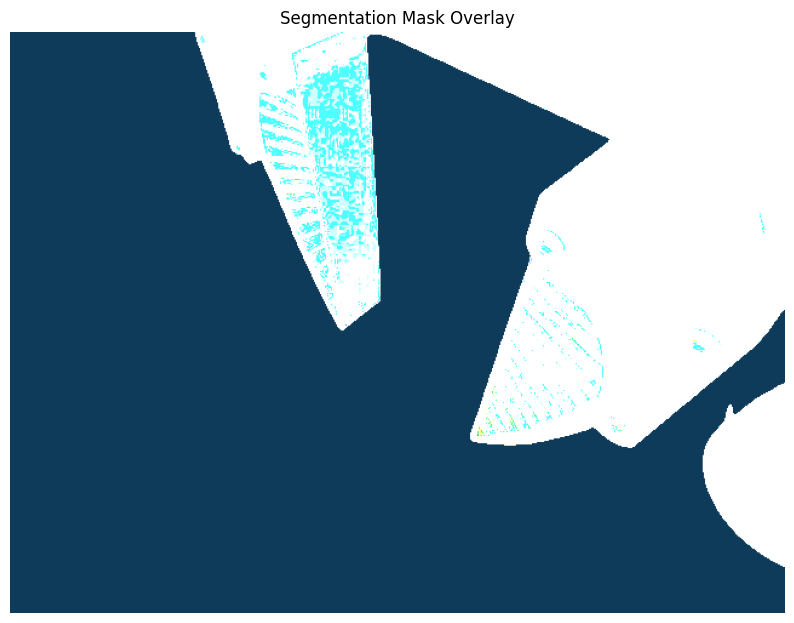

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_segmentation_mask(image, mask, alpha=0.5):
    """
    Visualize an image with its segmentation mask overlay.

    Args:
        image (np.array): The base image (H, W, 3).
        mask (np.array): The segmentation mask (H, W), with unique values for each class.
        alpha (float): Transparency level of the overlay (0 = only image, 1 = only mask).

    """
    # Generate a color map for the segmentation mask
    unique_classes = np.unique(mask)
    num_classes = len(unique_classes)
    colors = plt.cm.get_cmap('tab20', num_classes)(range(num_classes))[:, :3]  # RGB colors

    # Create a color mask
    color_mask = np.zeros_like(image, dtype=np.float32)
    for class_idx, color in zip(unique_classes, colors):
        color_mask[mask == class_idx] = color

    # Blend the image and the color mask
    blended_image = (1 - alpha) * image + alpha * color_mask

    # Display the result
    plt.figure(figsize=(10, 10))
    plt.imshow(blended_image)
    plt.axis('off')
    plt.title('Segmentation Mask Overlay')
    plt.show()

visualize_segmentation_mask(rgb_array, segmentation_mask)


In [3]:
import numpy as np
from PIL import Image


def extend_periodic_image(image: Image.Image, n: int) -> Image.Image:
    """
    Extend an image with a periodic pattern n-times in both width and height, maintaining resolution.

    Args:
        image (Image.Image): Input image (PIL.Image).
        n (int): Number of times to extend the image in each dimension.

    Returns:
        Image.Image: The extended and scaled-down image.
    """
    # Convert to numpy array for manipulation
    img_array = np.array(image)

    # Tile the image n-times in both dimensions
    tiled_array = np.tile(img_array, (2, 2, 1))

    # Create a PIL image from the tiled array
    extended_image = Image.fromarray(tiled_array)

    # Scale the image back to the original size
    # original_size = image.size  # (width, height)
    # scale_size = (original_size[0] * 6, original_size[1] * 4)
    scale_size = extended_image.size
    scaled_image = extended_image.resize(scale_size, Image.Resampling.LANCZOS)

    return scaled_image


# Example usage
if __name__ == "__main__":
    # Load an image
    img = Image.open("/home/irom-lab/projects/guided-data-collection/guided_dc/assets/table/Slide1.png")

    # Extend and scale the image
    extended_img = extend_periodic_image(img, 8)

    # Save or show the result
    extended_img.save("extended_image.png")
    extended_img.show()

/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/irom-lab/snap/code/common/.cache/gio-modules/libgiolibproxy.so
eog: symbol lookup error: /snap/core20/current/lib/x86_64-linux-gnu/libpthread.so.0: undefined symbol: __libc_pthread_init, version GLIBC_PRIVATE


In [3]:
import cv2
import numpy as np
real_rgb = cv2.imread("calibration/real/rgb.png")
real_depth = np.load("calibration/real/depth.npy")
real_seg_mask = cv2.imread("calibration/real/seg_mask.png")[...,0] // 255
segmented_color = cv2.bitwise_and(real_rgb, real_rgb, mask=real_seg_mask.astype(np.uint8))
segmented_depth = real_depth * real_seg_mask

# Visualize the segmented color image
cv2.imshow("Segmented Color Image", segmented_color)
cv2.waitKey(0)
cv2.destroyAllWindows()

# VIsulize the segmented depth image
cv2.imshow("Segmented Depth Image", (segmented_depth / 1000).astype(np.uint16))
cv2.waitKey(0)
cv2.destroyAllWindows()